In [1]:
include("EdwardsAndersonModel.jl")
using .EdwardsAndersonModel
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, Random, ProgressMeter
using CairoMakie

seed = 42
Random.seed!(seed)

init_logger(dir="../../logs", level=:Info)
println(names(EdwardsAndersonModel))

[:EdwardsAndersonModel, :calc_energy, :calc_gradient, :calc_gradient_no_constraints, :calc_round_trip_times, :initial_state, :metropolis_sampler]


In [2]:
N = 8
β_min = 0.1
β_max = 1.5
M = 20
η = 0.001
mcSteps = 2*10^4
eqSteps = 10^2
# target = 0.23
epochs = 300
batch_size = 10
Jh = randn(N, N, N)
Jv = randn(N, N, N)
Jz = randn(N, N, N)

@info """
Hyperparameters of Gaussian model:
--------------------
system size: $(N*N*N),
the number of replica: $M,
MCS: $mcSteps
Jh: $Jh,
Jv: $Jv,
Jz: $Jz
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_set = Utils.set_temperatures(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
_, exchange_prob_means = EdwardsAndersonModel.calc_gradient(N, init_β_set, Jh, Jv, Jz)

println(init_β_set)
println(exchange_prob_means)

[0.1, 0.11531864743932996, 0.13298390447236477, 0.1533552399495417, 0.17684718848715042, 0.20393778579786437, 0.23517829619981506, 0.27120443024848784, 0.31274928075809716, 0.36065824044647027, 0.415906204761356, 0.4796174099470457, 0.5530883100344796, 0.6378139582768096, 0.735518429864069, 0.8481899049862411, 0.9781211261470709, 1.1279560529911445, 1.3007436640194396, 1.5]
[0.6808384562115176, 0.6351092686571189, 0.5857533252039144, 0.531532557352603, 0.48929296613917106, 0.4243917236969287, 0.3537843422693495, 0.3052701273146817, 0.25649614956095407, 0.20810982593949034, 0.16819382566121213, 0.14251914474554545, 0.14112592666364385, 0.1437997779346787, 0.17475239774439918, 0.17770752477764382, 0.24390023778937175, 0.3294945333626218, 0.37502125014288645]


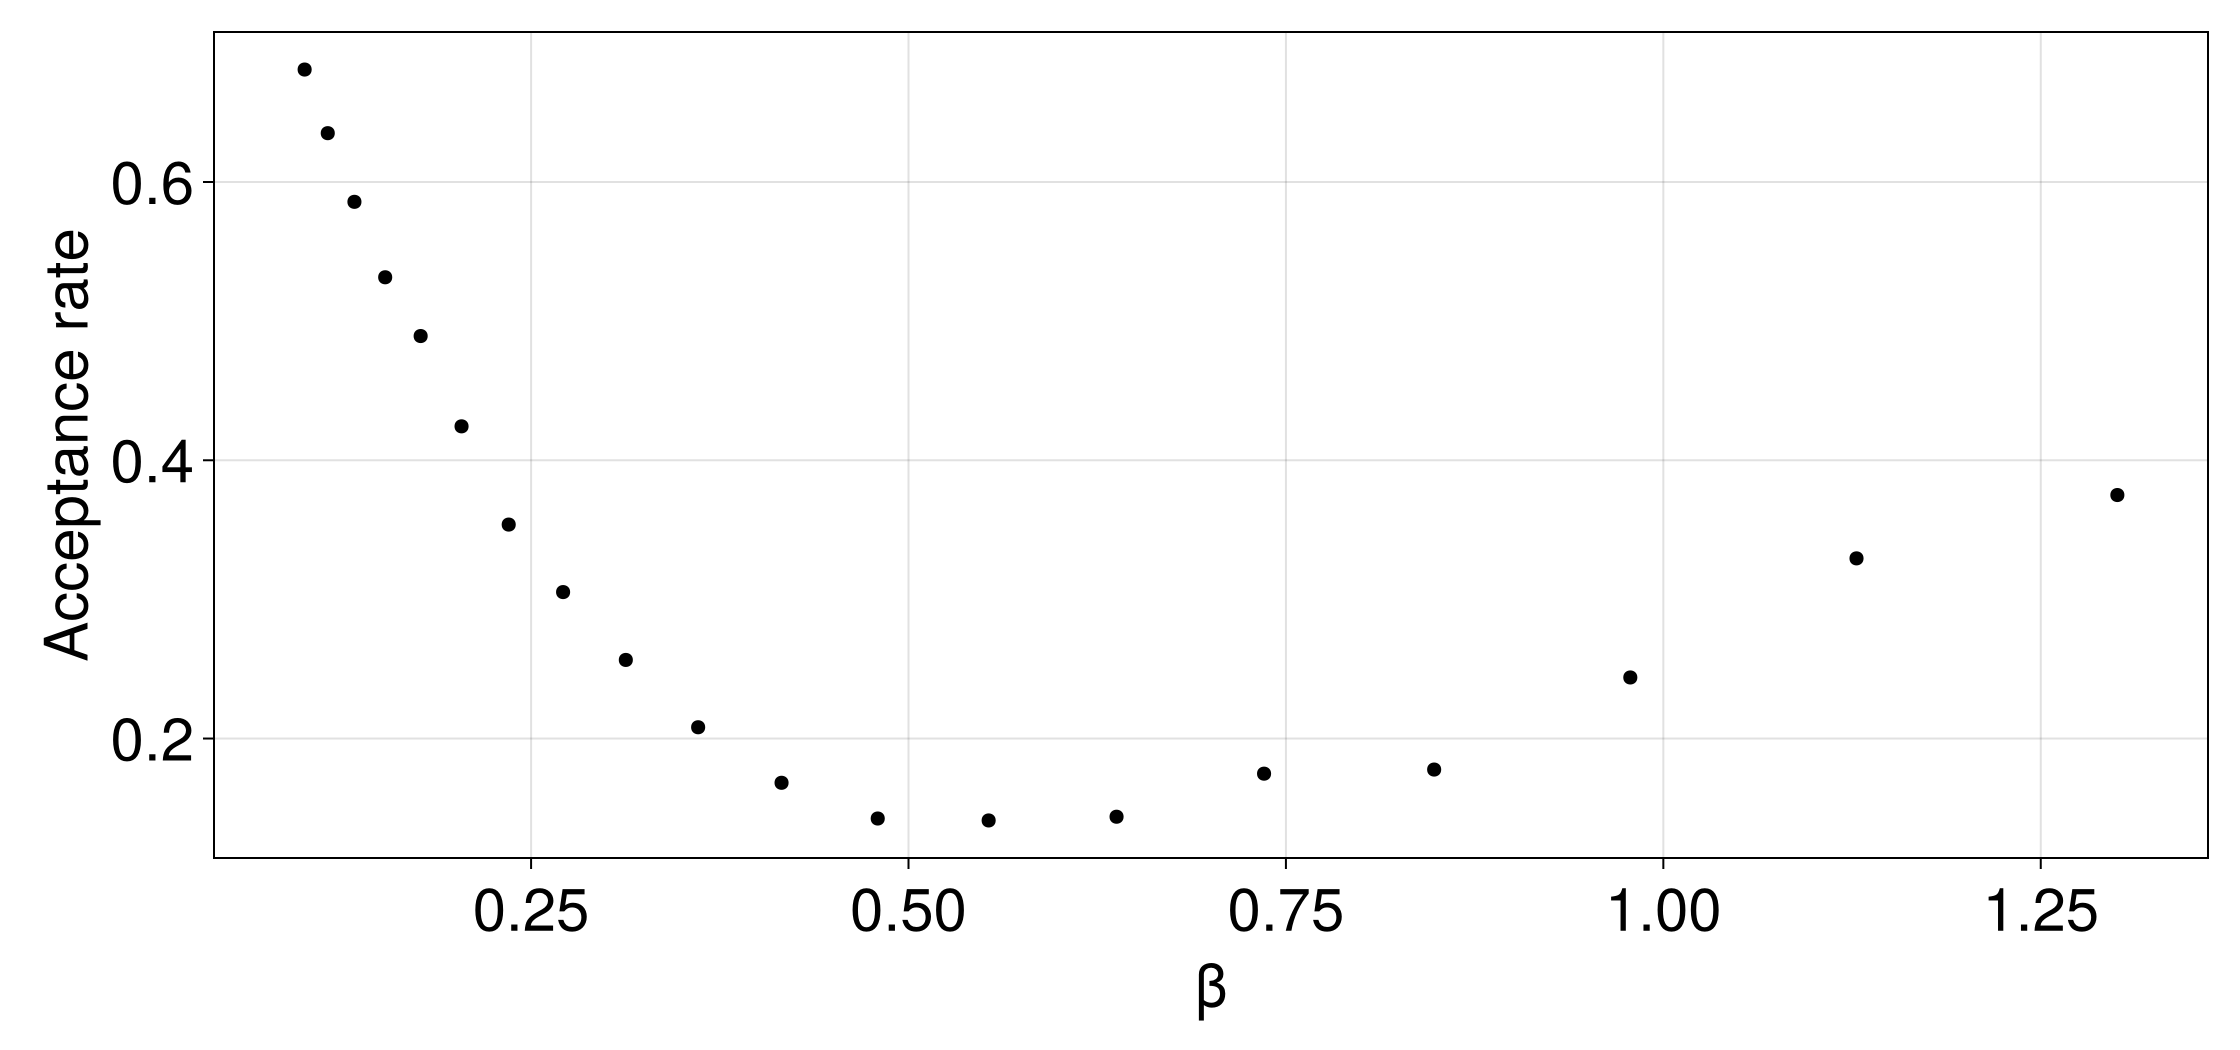

CairoMakie.Screen{IMAGE}


In [4]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
scatter!(ax1, init_β_set[1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [5]:
β_set = deepcopy(init_β_set)
β_set_trace = [β_set]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β_set)

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = EdwardsAndersonModel.calc_gradient_no_constraints(
            N, 
            β_set,
            Jh,
            Jv,
            Jz;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=5,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    grad_mean[1] = 0.0
    grad_mean[end] = 0.0
    setup, β_set = Optimisers.update(setup, β_set, grad_mean)

    push!(β_set_trace, deepcopy(β_set))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 6:48:00


In [6]:
dir = "../../plots/Edwards-Anderson_model_3d_Gaussian/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/Edwards-Anderson_model_3d_Gaussian/L=8/M=20"

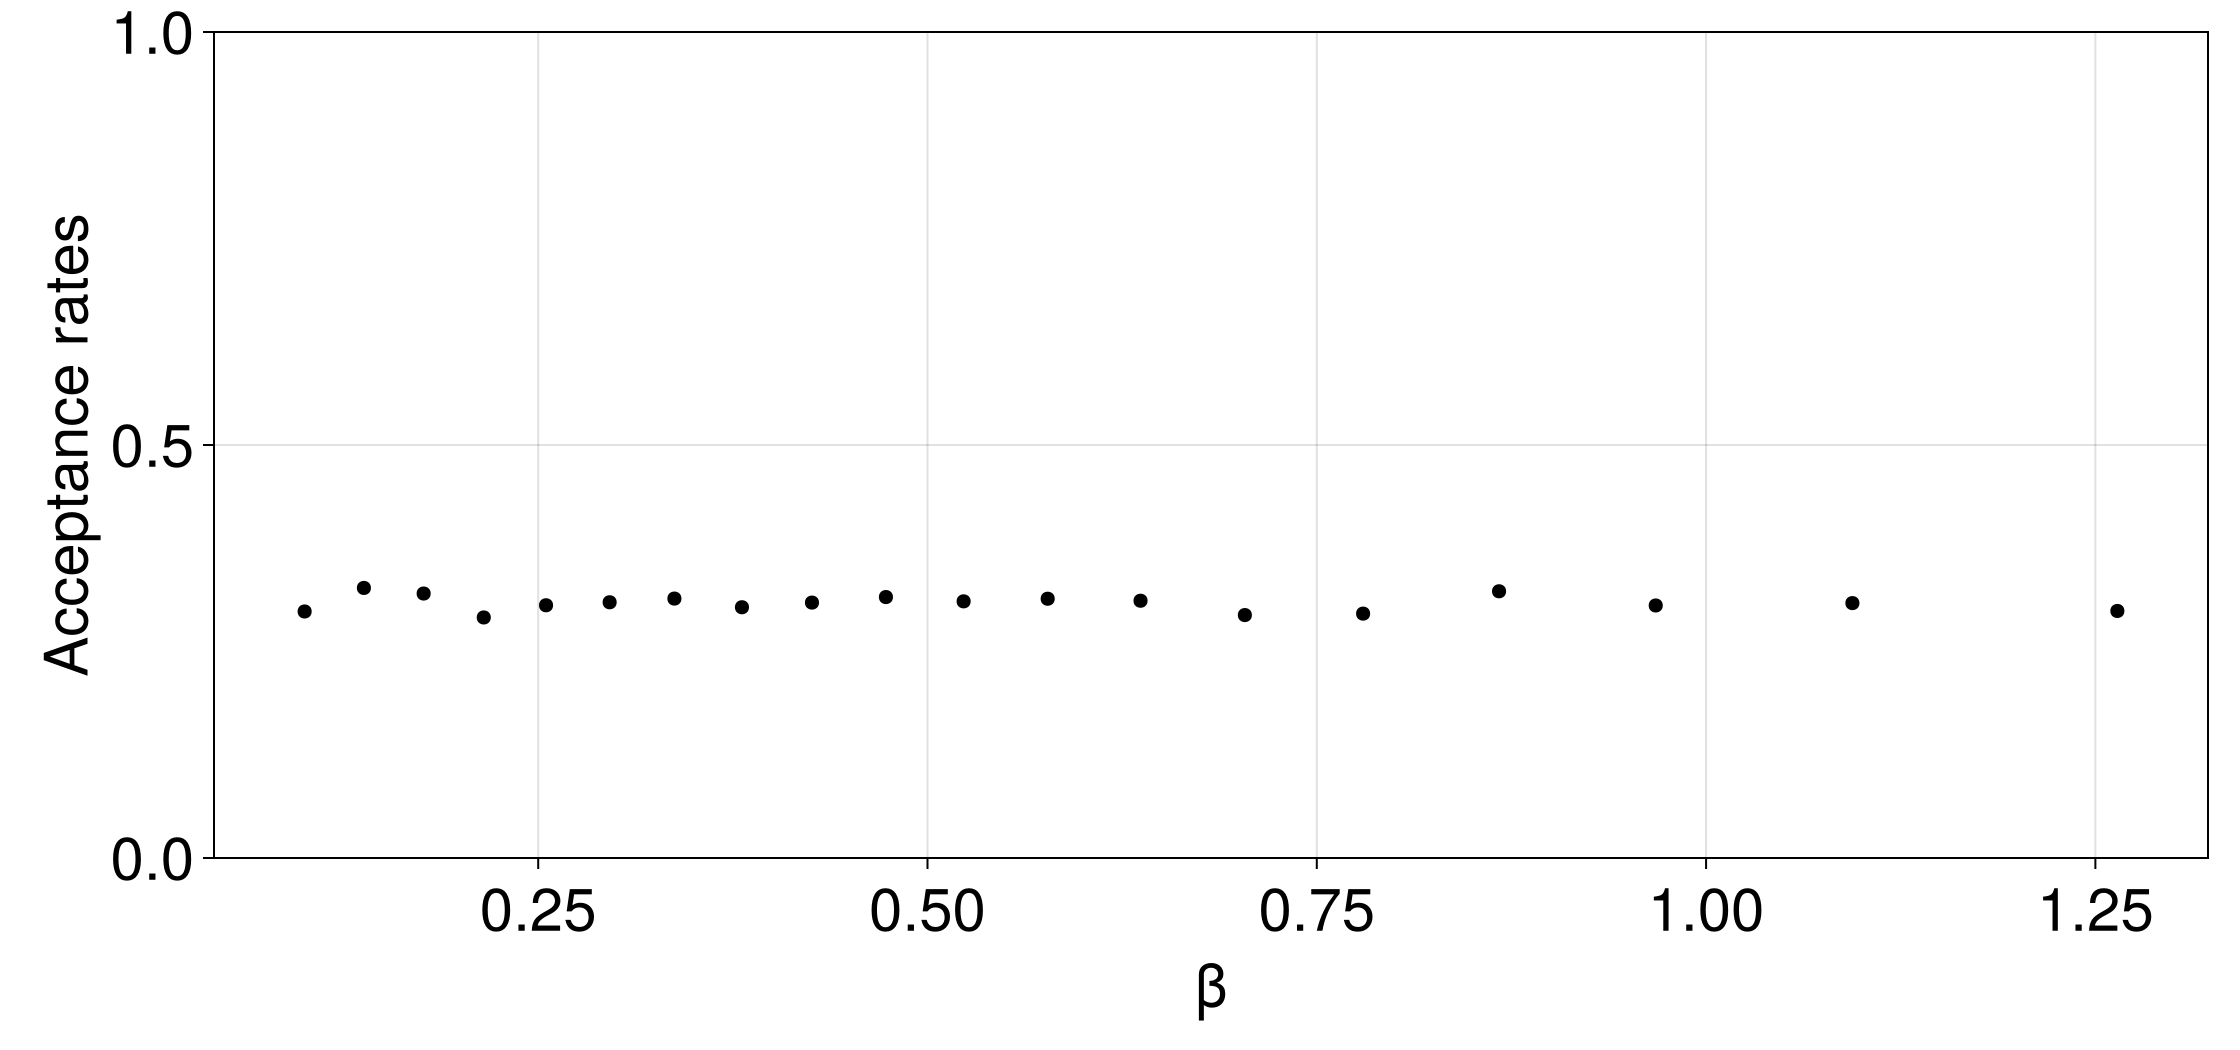

CairoMakie.Screen{IMAGE}


In [7]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rates")
ylims!(ax1, 0, 1)
scatter!(ax1, β_set_trace[end][1:(end-1)], exchange_prob_trace[end], color=:black, markersize=10)

display(fig1)

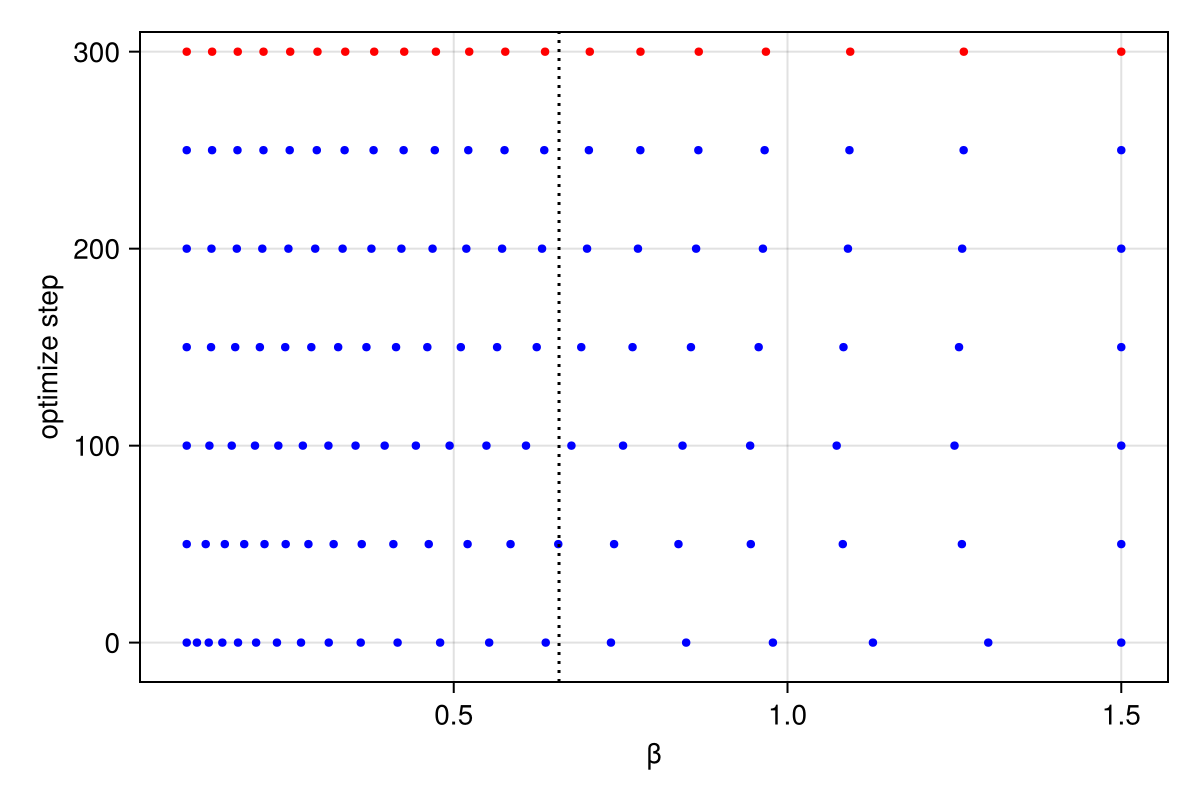

In [8]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step"
)
# xlims!(ax, -0.05, 2.05)
ylims!(ax, -20, epochs+10)

plot_interval = 50
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        y_values = fill(step, length(β_set))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_set, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
# β_c = 1.05 # T_c=0.951
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -10), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

β_dash = 0.6577177177177177
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")
display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

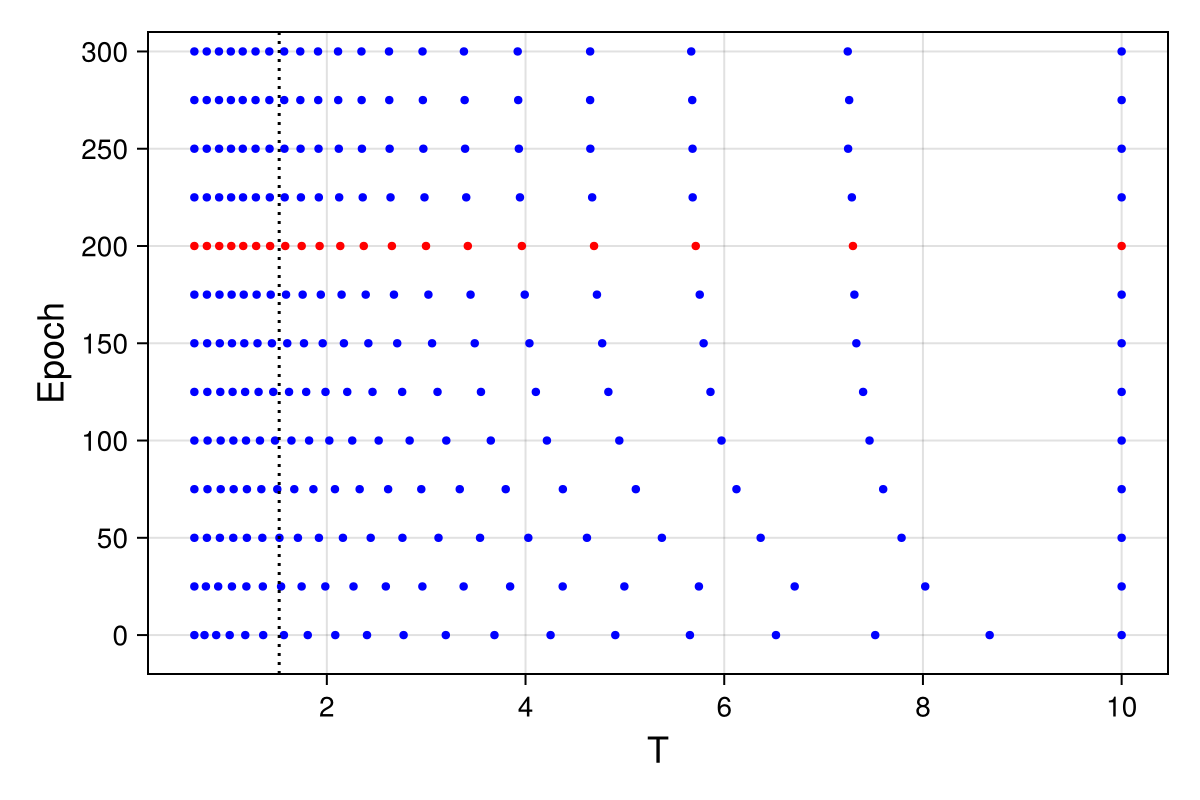

CairoMakie.Screen{IMAGE}


In [9]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "T",
    ylabel = "Epoch", 
    xlabelsize = 18,
    ylabelsize = 18, 
    yticks = 0:50:epochs
)

ylims!(ax, -20, epochs+10)

plot_interval = 25
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        T_values = 1 ./ β_set
        y_values = fill(step, length(T_values))
        marker_color = (step == 200) ? :red : :blue

        scatter!(ax, T_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
# T_c = 0.951
# vlines!(ax, [T_c], color=:black, linestyle=:dot, label="Critical Tc")
# text!(
#     ax,
#     L"T_c \approx %$(round(T_c, digits=3))", 
#     position = (T_c, -10), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

T_dash = 1/0.6577177177177177
vlines!(ax, [T_dash], color=:black, linestyle=:dot, label="T at maximum specific heat")

display(fig)

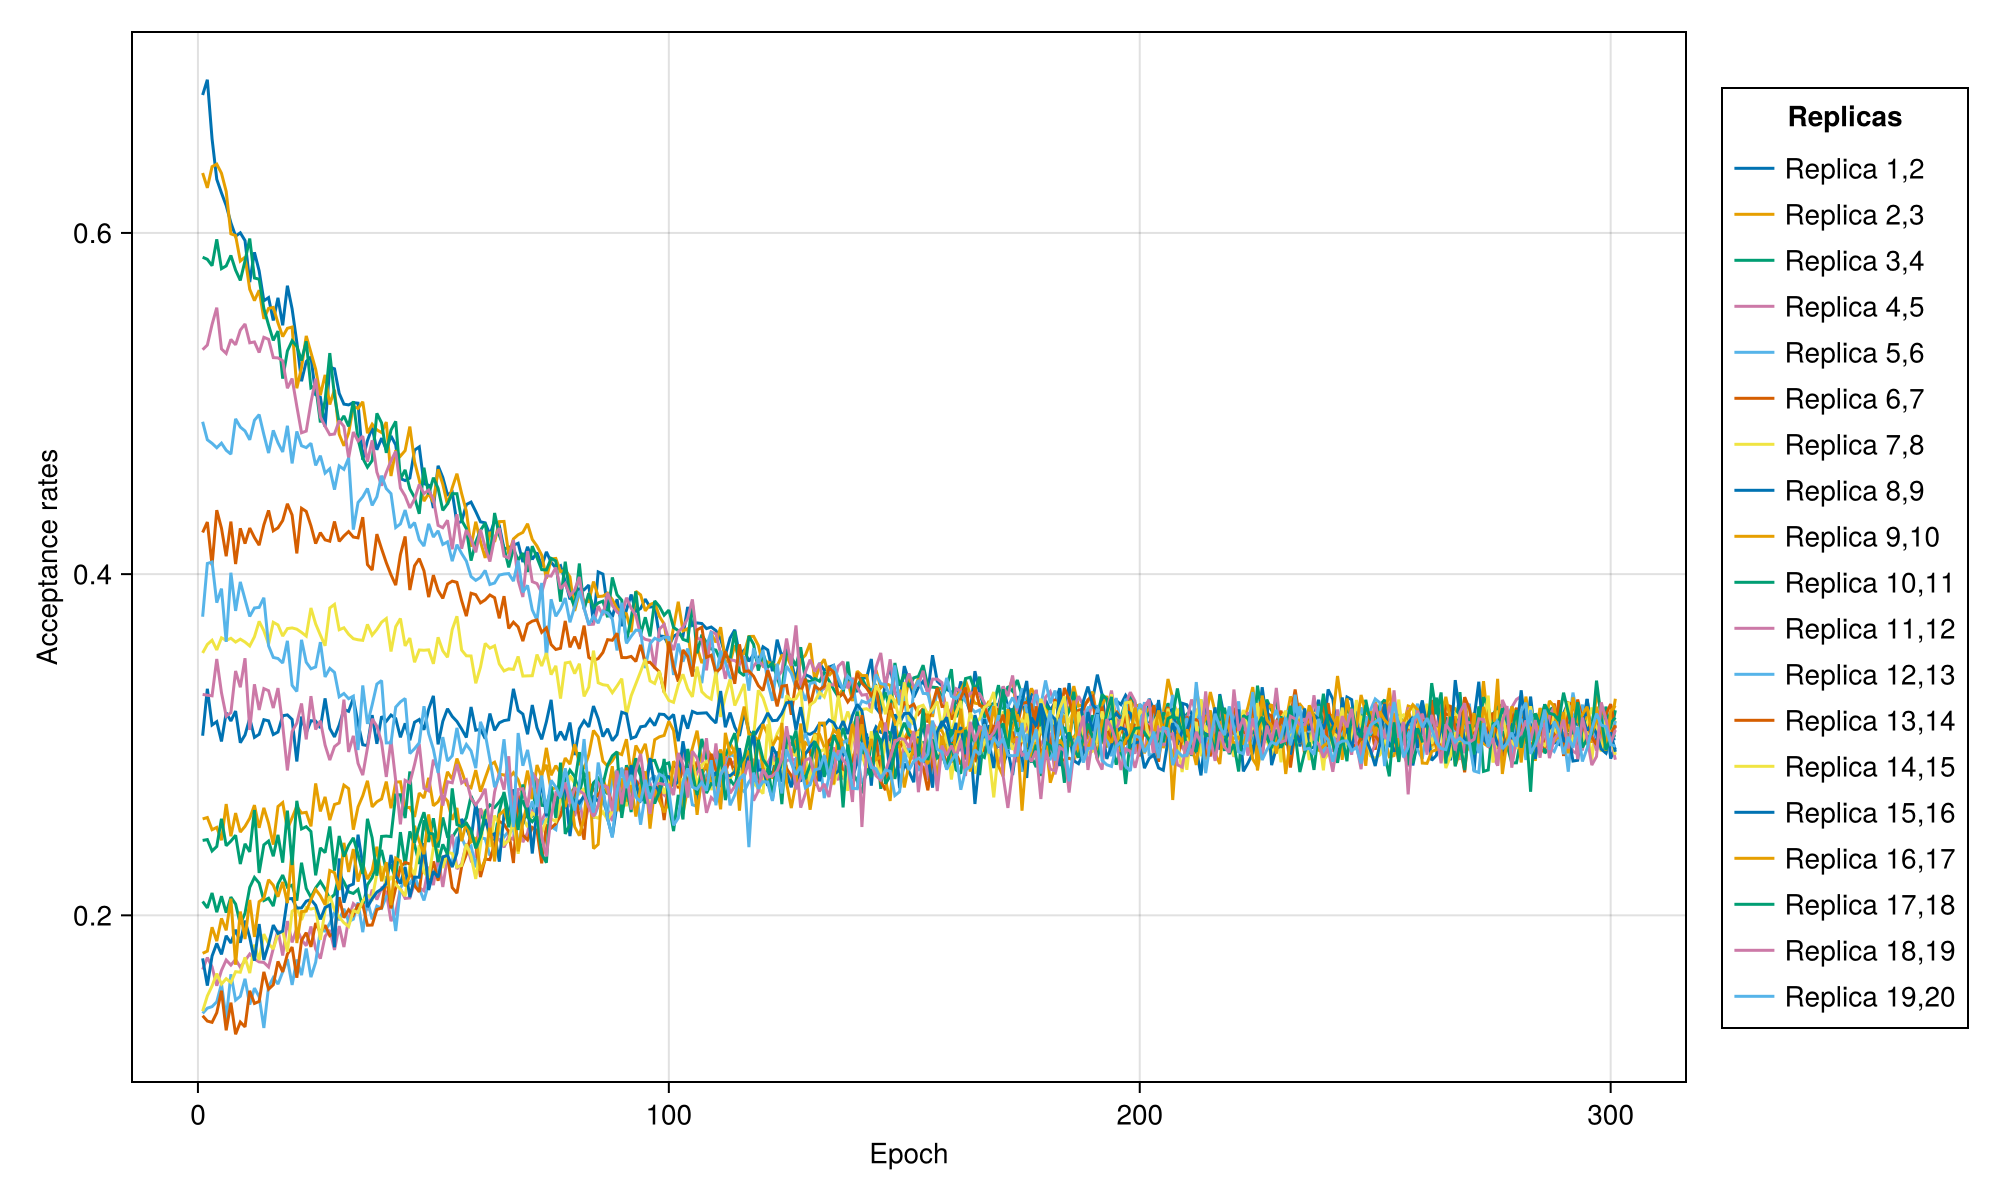

In [10]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates"
)
# ylims!(ax2, 0, 1)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

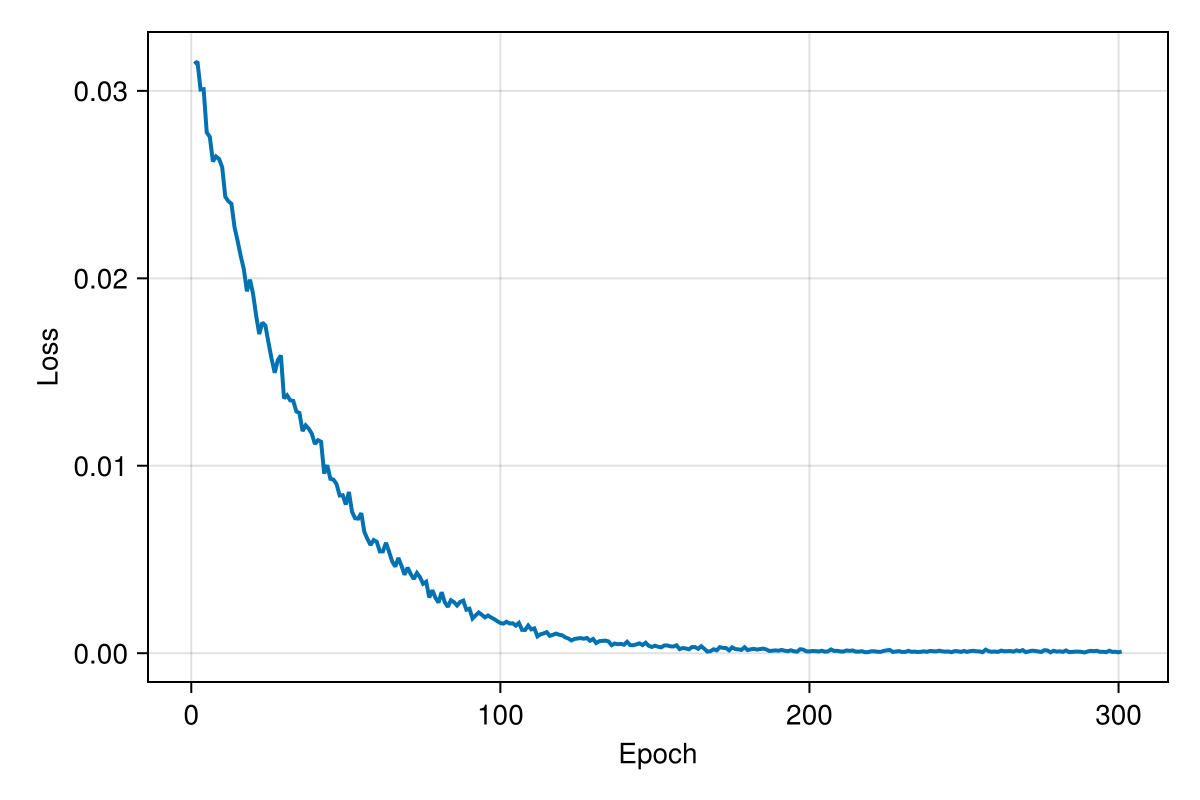

In [11]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [12]:
print(β_set_trace[end])

[0.1, 0.1380597973998756, 0.17643461718755873, 0.21503725190248932, 0.2550303889859351, 0.29587643562114935, 0.33746587513440857, 0.38084713447032825, 0.42581237580845077, 0.47330099478006354, 0.523203418580612, 0.5771871940418662, 0.6368095626634077, 0.703809709618951, 0.7797455761607252, 0.8670500985647474, 0.9676633559347921, 1.0939706569086167, 1.2641258521737058, 1.5]